In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import math
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout
import time
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from tqdm import tqdm

2025-09-02 16:03:24.879459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756829005.079260      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756829005.129443      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [3]:
movies = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/movies.csv")
ratings = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/ratings.csv")

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
class IGMCDataProcessor:
    """
    Class for processing MovieLens data and creating subgraphs for IGMC model.
    
    This class handles the conversion of rating data into graph structures suitable
    for the Inductive Graph-based Matrix Completion (IGMC) model. It creates
    bipartite graphs where users and movies are nodes, and ratings are edge weights.
    """
    
    def __init__(self, ratings_df, movies_df):
        """
        Initialize the data processor.
        
        Args:
            ratings_df (pd.DataFrame): DataFrame containing user ratings with columns:
                                     ['userId', 'movieId', 'rating']
            movies_df (pd.DataFrame): DataFrame containing movie information
        """
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        
        # Mappings between original IDs and graph node indices
        self.user_mapping = {}          # Original user ID -> graph node index
        self.movie_mapping = {}         # Original movie ID -> graph node index
        self.reverse_user_mapping = {}  # Graph node index -> original user ID
        self.reverse_movie_mapping = {} # Graph node index -> original movie ID
        
        # The main bipartite graph
        self.graph = None
        
    def create_mappings(self):
        """
        Create mappings between original IDs and graph node indices.
        
        Users get indices 0 to num_users-1, movies get indices num_users to num_users+num_movies-1.
        This ensures no overlap between user and movie node indices in the bipartite graph.
        """
        # Get unique users and movies, sorted for consistent mapping
        unique_users = sorted(self.ratings_df['userId'].unique())
        unique_movies = sorted(self.ratings_df['movieId'].unique())
        
        # Create user mappings (starting from index 0)
        self.user_mapping = {user: idx for idx, user in enumerate(unique_users)}
        
        # Create movie mappings (starting after all user indices)
        self.movie_mapping = {
            movie: idx + len(unique_users) 
            for idx, movie in enumerate(unique_movies)
        }
        
        # Create reverse mappings for easy lookup
        self.reverse_user_mapping = {idx: user for user, idx in self.user_mapping.items()}
        self.reverse_movie_mapping = {idx: movie for movie, idx in self.movie_mapping.items()}
        
        print(f"Number of users: {len(unique_users)}")
        print(f"Number of movies: {len(unique_movies)}")
        
    def build_bipartite_graph(self):
        """
        Build the bipartite user-movie graph.
        
        Creates a NetworkX graph where:
        - User nodes have attribute 'node_type': 'user'
        - Movie nodes have attribute 'node_type': 'movie'
        - Edges connect users to movies with 'rating' as edge attribute
        """
        self.graph = nx.Graph()
        
        # Add all user nodes with type annotation
        for user_id in self.user_mapping.values():
            self.graph.add_node(user_id, node_type='user')
        
        # Add all movie nodes with type annotation
        for movie_id in self.movie_mapping.values():
            self.graph.add_node(movie_id, node_type='movie')
        
        # Add edges with ratings as edge attributes
        for _, row in self.ratings_df.iterrows():
            user_node = self.user_mapping[row['userId']]
            movie_node = self.movie_mapping[row['movieId']]
            # Add edge between user and movie with rating as weight
            self.graph.add_edge(user_node, movie_node, rating=row['rating'])
            
        print(f"Graph created with {self.graph.number_of_nodes()} nodes and {self.graph.number_of_edges()} edges")
        
    def extract_subgraph(self, user_id, movie_id, hop=1):
        """
        Extract a subgraph centered around a user-movie pair.
        
        This method creates a local subgraph by including all nodes within 'hop' steps
        from the target user and movie nodes. This is essential for IGMC as it operates
        on local graph structures rather than the full graph.
        
        Args:
            user_id (int): Original user ID
            movie_id (int): Original movie ID
            hop (int): Number of hops to include in the subgraph (default: 1)
            
        Returns:
            tuple: (subgraph, user_node_idx, movie_node_idx)
                - subgraph: NetworkX subgraph
                - user_node_idx: Target user's node index in the main graph
                - movie_node_idx: Target movie's node index in the main graph
        """
        # Convert original IDs to graph node indices
        user_node = self.user_mapping[user_id]
        movie_node = self.movie_mapping[movie_id]
        
        # Initialize with target nodes
        nodes_to_include = set([user_node, movie_node])
        
        # Perform hop-based expansion
        current_nodes = set([user_node, movie_node])
        for _ in range(hop):
            next_nodes = set()
            # For each node in current hop, add all its neighbors
            for node in current_nodes:
                next_nodes.update(self.graph.neighbors(node))
            nodes_to_include.update(next_nodes)
            current_nodes = next_nodes
            
        # Create the subgraph with selected nodes
        subgraph = self.graph.subgraph(nodes_to_include)
        
        return subgraph, user_node, movie_node
    
    def subgraph_to_features(self, subgraph, target_user, target_movie):
        """
        Convert a subgraph to feature matrices for GNN input.
        
        This method transforms the NetworkX subgraph into numerical features
        that can be fed into the IGMC model:
        - Node features: encode node type and connectivity
        - Adjacency matrix: represents graph structure
        - Edge features: encode rating information
        
        Args:
            subgraph: NetworkX subgraph
            target_user (int): Target user's node index in main graph
            target_movie (int): Target movie's node index in main graph
            
        Returns:
            dict: Dictionary containing:
                - 'node_features': Node feature matrix (num_nodes, 2)
                - 'adj_matrix': Adjacency matrix (num_nodes, num_nodes)
                - 'edge_features': Edge features with ratings (num_edges, 3)
                - 'target_user_idx': Index of target user in subgraph
                - 'target_movie_idx': Index of target movie in subgraph
                - 'num_nodes': Number of nodes in subgraph
        """
        # Get nodes and create local mapping for this subgraph
        nodes = list(subgraph.nodes())
        node_mapping = {node: idx for idx, node in enumerate(nodes)}
        
        # Create node features: [node_type, degree]
        node_features = []
        for node in nodes:
            # Binary feature: 1.0 for users, 0.0 for movies
            node_type = 1.0 if subgraph.nodes[node]['node_type'] == 'user' else 0.0
            # Degree centrality as a structural feature
            degree = subgraph.degree(node)
            node_features.append([node_type, degree])
            
        # Create adjacency matrix
        num_nodes = len(nodes)
        adj_matrix = np.zeros((num_nodes, num_nodes))
        edge_features = []
        
        # Fill adjacency matrix and collect edge features
        for u, v, data in subgraph.edges(data=True):
            # Get local indices in the subgraph
            u_idx = node_mapping[u]
            v_idx = node_mapping[v]
            
            # Set adjacency (undirected graph)
            adj_matrix[u_idx, v_idx] = 1.0
            adj_matrix[v_idx, u_idx] = 1.0
            
            # Store edge features: [source_idx, target_idx, normalized_rating]
            rating = data.get('rating', 0.0) / 5.0  # Normalize rating to [0, 1]
            edge_features.append([u_idx, v_idx, rating])
            
        # Get target node indices in the subgraph coordinate system
        target_user_idx = node_mapping[target_user]
        target_movie_idx = node_mapping[target_movie]
        
        return {
            'node_features': np.array(node_features, dtype=np.float32),
            'adj_matrix': adj_matrix.astype(np.float32),
            'edge_features': np.array(edge_features, dtype=np.float32),
            'target_user_idx': target_user_idx,
            'target_movie_idx': target_movie_idx,
            'num_nodes': num_nodes
        }

In [7]:
class GNN(Model):
    """Base GNN class with GCN message passing and sum pooling"""
    
    def __init__(self, num_features, num_classes, latent_dim=[32, 32, 32, 1], 
                 regression=False, adj_dropout=0.2, force_undirected=False):
        super(GNN, self).__init__()
        self.regression = regression
        self.adj_dropout = adj_dropout
        self.force_undirected = force_undirected
        self.latent_dim = latent_dim
        
        # Define GCN layers
        self.gcn_layers = []
        self.gcn_layers.append(GCNLayer(latent_dim[0]))
        for i in range(len(latent_dim) - 1):
            self.gcn_layers.append(GCNLayer(latent_dim[i + 1]))
        
        # Define fully connected layers
        self.lin1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        if regression:
            self.lin2 = Dense(1)  # Single output for regression
        else:
            self.lin2 = Dense(num_classes)  # Class logits for classification
    
    def call(self, inputs, training=False):
        x, edge_index, batch = inputs['x'], inputs['edge_index'], inputs['batch']
        
        # Randomly drop edges from the adjacency matrix during training (regularization)
        if self.adj_dropout > 0 and training:
            edge_index = self.dropout_adj(edge_index, self.adj_dropout)
        
        # Apply GCN layers with tanh activation and keep intermediate states
        concat_states = []
        for gcn_layer in self.gcn_layers:
            x = tf.nn.tanh(gcn_layer([x, edge_index]))
            concat_states.append(x)
        
        # Concatenate states from all GCN layers
        concat_states = tf.concat(concat_states, axis=1)
        
        # Apply global sum pooling to get graph-level representation
        x = self.global_add_pool(concat_states, batch)
        
        # Pass through dense layers with dropout
        x = self.lin1(x)
        x = self.dropout(x, training=training)
        x = self.lin2(x)
        
        # Return regression output or log-softmax probabilities for classification
        if self.regression:
            return x[:, 0]
        else:
            return tf.nn.log_softmax(x, axis=-1)
    
    def global_add_pool(self, x, batch):
        """Global sum pooling: aggregates node features into a single graph embedding"""
        num_graphs = tf.reduce_max(batch) + 1
        result = tf.zeros((num_graphs, x.shape[1]), dtype=x.dtype)
        
        for i in range(num_graphs):
            mask = tf.equal(batch, i)
            pooled = tf.reduce_sum(tf.boolean_mask(x, mask), axis=0)
            result = tf.tensor_scatter_nd_update(result, [[i]], [pooled])
        
        return result
    
    def dropout_adj(self, edge_index, p):
        """Randomly removes edges from the adjacency matrix with probability p"""
        num_edges = edge_index.shape[1]
        mask = tf.random.uniform((num_edges,)) > p
        return tf.boolean_mask(edge_index, mask, axis=1)

class GCNLayer(layers.Layer):
    """Graph Convolutional Layer (basic GCN)"""
    
    def __init__(self, out_channels):
        super(GCNLayer, self).__init__()
        self.out_channels = out_channels
        self.linear = Dense(out_channels, use_bias=False)
    
    def build(self, input_shape):
        super(GCNLayer, self).build(input_shape)
    
    def call(self, inputs):
        x, edge_index = inputs
        
        # Apply linear transformation to node features
        x = self.linear(x)
        
        # Extract source and target indices of edges
        row, col = edge_index[0], edge_index[1]
        
        # Initialize aggregated messages (same shape as node features)
        num_nodes = tf.shape(x)[0]
        aggregated = tf.zeros_like(x)
        
        # Message passing: aggregate features from neighbors
        for i in range(tf.shape(edge_index)[1]):
            source_idx = col[i]
            target_idx = row[i]
            message = x[source_idx]
            aggregated = tf.tensor_scatter_nd_add(
                aggregated, [[target_idx]], [message]
            )
        
        return aggregated

class RGCNLayer(layers.Layer):
    """Relational Graph Convolutional Layer (R-GCN)"""
    
    def __init__(self, out_channels, num_relations, num_bases=None):
        super(RGCNLayer, self).__init__()
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases or num_relations
        
        # Basis decomposition for relation-specific weights
        self.basis_weights = self.add_weight(
            shape=(self.num_bases, out_channels),
            initializer='glorot_uniform',
            trainable=True,
            name='basis_weights'
        )
        
        self.relation_weights = self.add_weight(
            shape=(num_relations, self.num_bases),
            initializer='glorot_uniform',
            trainable=True,
            name='relation_weights'
        )
    
    def call(self, inputs):
        x, edge_index, edge_type = inputs
        
        # Compute weight matrices for each relation type
        weight_matrices = tf.matmul(self.relation_weights, self.basis_weights)
        
        # Initialize output representation
        output = tf.zeros_like(x[:, :self.out_channels])
        
        # Process each relation type separately
        for r in range(self.num_relations):
            # Select edges that belong to the current relation
            relation_mask = tf.equal(edge_type, r)
            relation_edges = tf.boolean_mask(edge_index, relation_mask, axis=1)
            
            if tf.shape(relation_edges)[1] > 0:
                # Apply transformation with relation-specific weights
                transformed_x = tf.matmul(x, weight_matrices[r:r+1])
                
                # Message passing for nodes connected by this relation
                row, col = relation_edges[0], relation_edges[1]
                for i in range(tf.shape(relation_edges)[1]):
                    source_idx = col[i]
                    target_idx = row[i]
                    message = transformed_x[source_idx]
                    output = tf.tensor_scatter_nd_add(
                        output, [[target_idx]], [message]
                    )
        
        return output

class DGCNN(GNN):
    """Deep Graph Convolutional Neural Network (DGCNN) with SortPooling"""
    
    def __init__(self, num_features, num_classes, dataset_graphs=None, 
                 latent_dim=[32, 32, 32, 1], k=30, regression=False, 
                 adj_dropout=0.2, force_undirected=False):
        super(DGCNN, self).__init__(
            num_features, num_classes, latent_dim, regression, adj_dropout, force_undirected
        )
        
        # Determine k for sort pooling (either fixed or dataset-based percentile)
        if k < 1 and dataset_graphs is not None:
            node_nums = sorted([g.num_nodes for g in dataset_graphs])
            k = node_nums[int(math.ceil(k * len(node_nums))) - 1]
            k = max(10, k)  # Ensure minimum of 10
        self.k = int(k)
        print(f'k used in sortpooling is: {self.k}')
        
        # 1D convolution layers for processing pooled graph embeddings
        conv1d_channels = [16, 32]
        self.total_latent_dim = sum(latent_dim)
        conv1d_kws = [self.total_latent_dim, 5]
        
        self.conv1d_1 = Conv1D(
            conv1d_channels[0], conv1d_kws[0], 
            strides=conv1d_kws[0], activation='relu'
        )
        self.maxpool1d = MaxPooling1D(pool_size=2, strides=2)
        self.conv1d_2 = Conv1D(
            conv1d_channels[1], conv1d_kws[1], 
            strides=1, activation='relu'
        )
        
        # Calculate dimension after Conv1D and pooling layers
        dense_dim = int((k - 2) / 2 + 1)
        self.dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        
        # Fully connected layer before output
        self.lin1 = Dense(128, activation='relu')
    
    def call(self, inputs, training=False):
        x, edge_index, batch = inputs['x'], inputs['edge_index'], inputs['batch']
        
        # Randomly drop edges during training for regularization
        if self.adj_dropout > 0 and training:
            edge_index = self.dropout_adj(edge_index, self.adj_dropout)
        
        # Apply GCN layers and concatenate outputs
        concat_states = []
        for gcn_layer in self.gcn_layers:
            x = tf.nn.tanh(gcn_layer([x, edge_index]))
            concat_states.append(x)
        
        concat_states = tf.concat(concat_states, axis=1)
        
        # Apply global sort pooling
        x = self.global_sort_pool(concat_states, batch, self.k)
        
        # Process pooled features with Conv1D layers
        x = tf.expand_dims(x, axis=1)  # Add a temporal/channel dimension
        x = self.conv1d_1(x)
        x = self.maxpool1d(x)
        x = self.conv1d_2(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1))  # Flatten for dense layers
        
        # Fully connected + output layers
        x = self.lin1(x)
        x = self.dropout(x, training=training)
        x = self.lin2(x)
        
        # Return regression output or classification probabilities
        if self.regression:
            return x[:, 0]
        else:
            return tf.nn.log_softmax(x, axis=-1)
    
    def global_sort_pool(self, x, batch, k):
        """
        Global sort pooling: selects the top-k nodes per graph based on feature values.
        
        Args:
            x (Tensor): Node feature matrix of shape [num_nodes, num_features].
            batch (Tensor): Batch assignment vector mapping nodes to graphs.
            k (int): Number of nodes to keep per graph.
        
        Returns:
            Tensor: Pooled graph embeddings of shape [num_graphs, k * num_features].
        """
        num_graphs = tf.reduce_max(batch) + 1
        result = []
        
        for i in range(num_graphs):
            mask = tf.equal(batch, i)
            graph_nodes = tf.boolean_mask(x, mask)
            
            # Sort nodes by their last feature (descending order)
            sorted_indices = tf.argsort(graph_nodes[:, -1], direction='DESCENDING')
            sorted_nodes = tf.gather(graph_nodes, sorted_indices)
            
            # Keep top-k nodes, pad with zeros if fewer than k
            if tf.shape(sorted_nodes)[0] >= k:
                pooled = sorted_nodes[:k]
            else:
                padding_size = k - tf.shape(sorted_nodes)[0]
                padding = tf.zeros((padding_size, tf.shape(sorted_nodes)[1]))
                pooled = tf.concat([sorted_nodes, padding], axis=0)
            
            # Flatten graph representation
            result.append(tf.reshape(pooled, (-1,)))
        
        return tf.stack(result)

class DGCNN_RS(DGCNN):
    """Deep Graph Convolutional Neural Network with Relational GCN (R-GCN) layers"""
    
    def __init__(self, num_features, num_classes, dataset_graphs=None, 
                 latent_dim=[32, 32, 32, 1], k=30, num_relations=5, num_bases=2,
                 regression=False, adj_dropout=0.2, force_undirected=False):
        super(DGCNN_RS, self).__init__(
            num_features, num_classes, dataset_graphs, latent_dim, k, 
            regression, adj_dropout, force_undirected
        )
        
        # Replace standard GCN layers with R-GCN layers
        self.gcn_layers = []
        self.gcn_layers.append(RGCNLayer(latent_dim[0], num_relations, num_bases))
        for i in range(len(latent_dim) - 1):
            self.gcn_layers.append(RGCNLayer(latent_dim[i + 1], num_relations, num_bases))
    
    def call(self, inputs, training=False):
        x, edge_index, edge_type, batch = (
            inputs['x'], inputs['edge_index'], inputs['edge_type'], inputs['batch']
        )
        
        # Apply dropout to edges while preserving relation types
        if self.adj_dropout > 0 and training:
            edge_index, edge_type = self.dropout_adj_with_type(
                edge_index, edge_type, self.adj_dropout
            )
        
        # Apply R-GCN layers with tanh activation
        concat_states = []
        for rgcn_layer in self.gcn_layers:
            x = tf.nn.tanh(rgcn_layer([x, edge_index, edge_type]))
            concat_states.append(x)
        
        # Concatenate outputs from all R-GCN layers
        concat_states = tf.concat(concat_states, axis=1)
        
        # Apply sort pooling to obtain fixed-size graph representations
        x = self.global_sort_pool(concat_states, batch, self.k)
        
        # Process pooled features with Conv1D layers
        x = tf.expand_dims(x, axis=1)  # Add channel dimension
        x = self.conv1d_1(x)
        x = self.maxpool1d(x)
        x = self.conv1d_2(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1))  # Flatten for dense layers
        
        # Fully connected + output layers
        x = self.lin1(x)
        x = self.dropout(x, training=training)
        x = self.lin2(x)
        
        # Regression or classification output
        if self.regression:
            return x[:, 0]
        else:
            return tf.nn.log_softmax(x, axis=-1)
    
    def dropout_adj_with_type(self, edge_index, edge_type, p):
        """
        Dropout edges from the adjacency matrix while preserving edge types.
        
        Args:
            edge_index (Tensor): Edge indices of shape [2, num_edges].
            edge_type (Tensor): Relation type for each edge, shape [num_edges].
            p (float): Dropout probability.
        
        Returns:
            Tuple[Tensor, Tensor]: Filtered edge_index and edge_type tensors.
        """
        num_edges = edge_index.shape[1]
        mask = tf.random.uniform((num_edges,)) > p
        return (tf.boolean_mask(edge_index, mask, axis=1), 
                tf.boolean_mask(edge_type, mask))

class IGMC(Model):
    """Inductive Graph-based Matrix Completion (IGMC) model"""
    
    def __init__(self, num_features, num_classes, latent_dim=[32, 32, 32, 32], 
                 num_relations=5, num_bases=2, regression=True, adj_dropout=0.2,
                 force_undirected=False, side_features=False, n_side_features=0, 
                 multiply_by=1):
        super(IGMC, self).__init__()
        
        self.regression = regression
        self.adj_dropout = adj_dropout
        self.force_undirected = force_undirected
        self.multiply_by = multiply_by
        self.side_features = side_features
        self.latent_dim = latent_dim
        
        # Node embedding and hidden layers
        self.node_embedding = Dense(latent_dim[0], activation='tanh')
        self.hidden_layers = []
        for i in range(1, len(latent_dim)):
            self.hidden_layers.append(Dense(latent_dim[i], activation='tanh'))
        
        # Final prediction layers
        total_dim = sum(latent_dim)
        self.lin1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        
        if regression:
            self.lin2 = Dense(1)  # Single output for rating prediction
        else:
            self.lin2 = Dense(num_classes)  # Multi-class output
    
    def build(self, input_shape):
        """Build the model layers (standard Keras build hook)."""
        super(IGMC, self).build(input_shape)
    
    def call(self, inputs, training=False):
        # Handle both dictionary and tuple/list inputs
        if isinstance(inputs, dict):
            node_features = inputs['node_features']
            adj_matrix = inputs['adj_matrix']
            edge_features = inputs['edge_features']
            target_user_idx = inputs['target_user_idx']
            target_movie_idx = inputs['target_movie_idx']
        else:
            # Unpack tuple/list format
            node_features = inputs[0]   # (batch, nodes, features)
            adj_matrix = inputs[1]      # (batch, nodes, nodes)
            edge_features = inputs[2]   # (batch, nodes, edge_features)
            target_user_idx = inputs[3] # (batch,)
            target_movie_idx = inputs[4] # (batch,)
        
        batch_size = tf.shape(node_features)[0]
        num_nodes = tf.shape(node_features)[1]
        
        # Initial node embeddings
        x = self.node_embedding(node_features)
        
        # Apply hidden layers with adjacency-based message passing
        for hidden_layer in self.hidden_layers:
            # Simple message passing: aggregate neighbor features
            messages = tf.matmul(adj_matrix, x)
            x = hidden_layer(x + messages * 0.1)  # Residual-style update
        
        # Extract user and movie embeddings using indices
        batch_indices = tf.range(batch_size, dtype=tf.int64)
        user_indices = tf.stack([batch_indices, tf.cast(target_user_idx, tf.int64)], axis=1)
        movie_indices = tf.stack([batch_indices, tf.cast(target_movie_idx, tf.int64)], axis=1)
        
        user_embeddings = tf.gather_nd(x, user_indices)
        movie_embeddings = tf.gather_nd(x, movie_indices)
        
        # Concatenate user and movie embeddings
        combined = tf.concat([user_embeddings, movie_embeddings], axis=1)
        
        # Final prediction layers
        x = self.lin1(combined)
        x = self.dropout(x, training=training)
        x = self.lin2(x)
        
        # Return regression value or classification probabilities
        if self.regression:
            return tf.squeeze(x, axis=-1) * self.multiply_by
        else:
            return tf.nn.log_softmax(x, axis=-1)

# Usage example:
def create_model(model_type='GNN', num_features=10, num_classes=2, **kwargs):
    """Factory function to create different GNN models"""
    
    if model_type == 'GNN':
        return GNN(num_features, num_classes, **kwargs)
    elif model_type == 'DGCNN':
        return DGCNN(num_features, num_classes, **kwargs)
    elif model_type == 'DGCNN_RS':
        return DGCNN_RS(num_features, num_classes, **kwargs)
    elif model_type == 'IGMC':
        # Set default regression=True for IGMC as it's typically used for rating prediction
        if 'regression' not in kwargs:
            kwargs['regression'] = True
        return IGMC(num_features, num_classes, **kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [8]:
def create_training_data(processor, ratings_df, max_samples=5000):
    """Create the training data"""
    # Sampling to reduce dataset size
    if len(ratings_df) > max_samples:
        sample_ratings = ratings_df.sample(n=max_samples, random_state=42)
    else:
        sample_ratings = ratings_df
    
    X_data = []
    y_data = []
    
    print("Creating subgraphs...")
    for _, row in tqdm(sample_ratings.iterrows(), total=len(sample_ratings)):
        user_id = row['userId']
        movie_id = row['movieId']
        rating = row['rating']
        
        try:
            subgraph, user_node, movie_node = processor.extract_subgraph(user_id, movie_id, hop=1)
            features = processor.subgraph_to_features(subgraph, user_node, movie_node)
            
            X_data.append(features)
            y_data.append(rating)
        except Exception as e:
            print(f"Error for user {user_id}, movie {movie_id}: {e}")
            continue
    
    return X_data, np.array(y_data)

def pad_and_batch_data(X_data, y_data, max_nodes=50):
    """Prepare the data for batch training"""
    batched_data = {
        'node_features': [],
        'adj_matrix': [],
        'edge_features': [],
        'target_user_idx': [],
        'target_movie_idx': []
    }
    
    valid_indices = []
    
    for i, features in enumerate(X_data):
        if features['num_nodes'] <= max_nodes:
            # Padding node_features
            padded_nodes = np.zeros((max_nodes, features['node_features'].shape[1]))
            padded_nodes[:features['num_nodes']] = features['node_features']
            
            # Padding adjacency matrix
            padded_adj = np.zeros((max_nodes, max_nodes))
            padded_adj[:features['num_nodes'], :features['num_nodes']] = features['adj_matrix']
            
            batched_data['node_features'].append(padded_nodes)
            batched_data['adj_matrix'].append(padded_adj)
            batched_data['target_user_idx'].append(features['target_user_idx'])
            batched_data['target_movie_idx'].append(features['target_movie_idx'])
            
            valid_indices.append(i)
    
    # Convert to numpy arrays
    for key in batched_data:
        batched_data[key] = np.array(batched_data[key])
    
    # Placeholder for edge_features (simplified)
    batched_data['edge_features'] = np.zeros((len(valid_indices), max_nodes, 1))
    
    return batched_data, y_data[valid_indices]

## 50 Epochs

Number of users: 610
Number of movies: 9724
Graph created with 10334 nodes and 100836 edges
Creating training data...
Creating subgraphs...


100%|██████████| 3000/3000 [02:32<00:00, 19.69it/s]


Creating test data...
Creating subgraphs...


100%|██████████| 1000/1000 [00:49<00:00, 20.36it/s]


Preparing batches...
Training data: 28 samples
Test data: 13 samples
Creating IGMC model...


I0000 00:00:1756829222.629050      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756829222.629833      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model built successfully!
Training model...
Epoch 1/50


I0000 00:00:1756829226.641402     101 service.cc:148] XLA service 0x7f12ec04e990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756829226.642021     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756829226.642047     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756829226.919253     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 12.1399 - mae: 3.0981

I0000 00:00:1756829228.360307     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 736ms/step - loss: 11.4237 - mae: 2.8483 - val_loss: 2.6562 - val_mae: 1.3614
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.6739 - mae: 2.0831 - val_loss: 2.5151 - val_mae: 1.1945
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4306 - mae: 1.8183 - val_loss: 2.8958 - val_mae: 1.4192
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.1367 - mae: 2.3411 - val_loss: 2.6157 - val_mae: 1.3569
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.2762 - mae: 2.4757 - val_loss: 2.1963 - val_mae: 1.0872
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9939 - mae: 2.0143 - val_loss: 1.8803 - val_mae: 1.0391
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1967 - mae: 1.8783 - val_loss: 2.2448 - val_mae: 1.2343
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4990 - mae: 1.6621 - val_loss: 2.6217 - val_mae: 1.3578
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5409 - mae: 2.0280 - val_loss

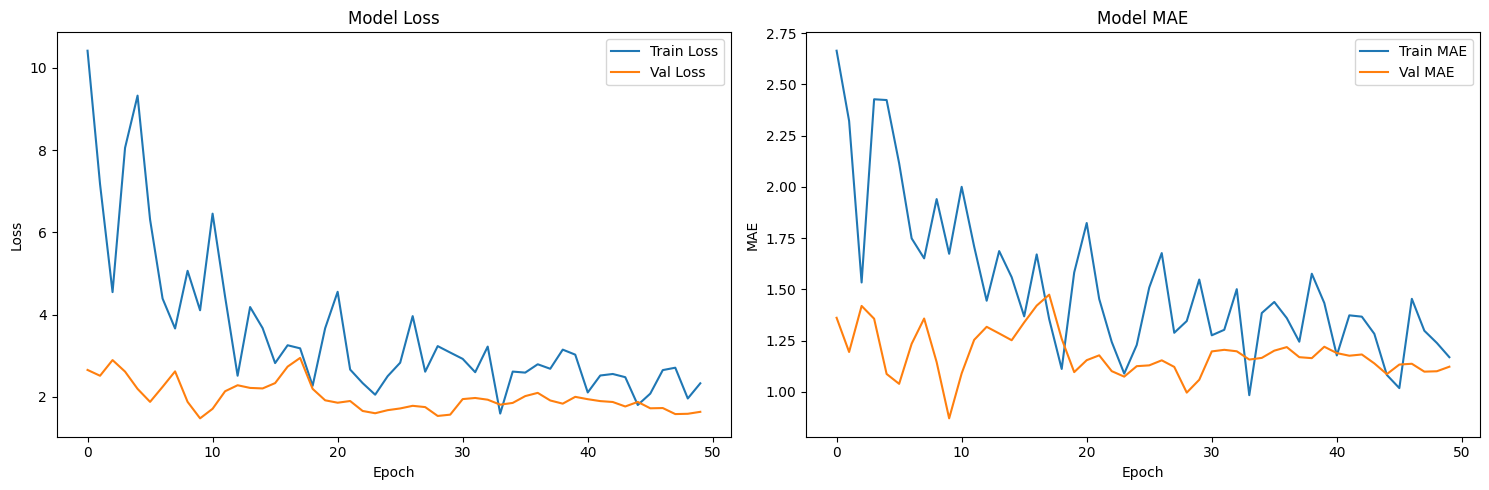

In [9]:
# Create data processor
processor = IGMCDataProcessor(ratings, movies)
processor.create_mappings()
processor.build_bipartite_graph()

# Train/test split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Create training and test data
print("Creating training data...")
X_train, y_train = create_training_data(processor, train_ratings, max_samples=3000)

print("Creating test data...")
X_test, y_test = create_training_data(processor, test_ratings, max_samples=1000)

# Prepare data for training
print("Preparing batches...")
X_train_batched, y_train_batched = pad_and_batch_data(X_train, y_train)
X_test_batched, y_test_batched = pad_and_batch_data(X_test, y_test)

print(f"Training data: {len(y_train_batched)} samples")
print(f"Test data: {len(y_test_batched)} samples")

# Create and compile the model
print("Creating IGMC model...")
model = create_model('IGMC', 
                    num_features=2,  # Adjust based on your node features
                    num_classes=1,   # For regression, this doesn't matter much
                    latent_dim=[32, 32, 16], 
                    regression=True,  # Set to True for rating prediction
                    multiply_by=5.0)  # Scale output to rating range

# Compile - use MAE for regression
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Build the model with the correct input shape
# Create a dummy input to build the model
dummy_input = [
    tf.zeros((1, 50, 2)),  # node_features: (batch, nodes, features)
    tf.zeros((1, 50, 50)), # adj_matrix: (batch, nodes, nodes)
    tf.zeros((1, 50, 1)),  # edge_features: (batch, nodes, 1)
    tf.zeros((1,), dtype=tf.int32),  # target_user_idx
    tf.zeros((1,), dtype=tf.int32),  # target_movie_idx
]

# Build the model
_ = model(dummy_input, training=False)

print("Model built successfully!")

# Prepare inputs for training (keep the same as before)
train_inputs = [
    X_train_batched['node_features'],
    X_train_batched['adj_matrix'],
    X_train_batched['edge_features'],
    X_train_batched['target_user_idx'],
    X_train_batched['target_movie_idx']
]

test_inputs = [
    X_test_batched['node_features'],
    X_test_batched['adj_matrix'],
    X_test_batched['edge_features'],
    X_test_batched['target_user_idx'],
    X_test_batched['target_movie_idx']
]

# Training
print("Training model...")
history = model.fit(
    train_inputs,
    y_train_batched,
    validation_data=(test_inputs, y_test_batched),
    epochs=50,
    batch_size=8,  # Reduce batch size if you have memory issues
    verbose=1
)

# Evaluation
print("Evaluating model...")
predictions = model.predict(test_inputs)
predictions = np.clip(predictions.flatten(), 0, 5)  # Clip between 0 and 5

mse = mean_squared_error(y_test_batched, predictions)
mae = mean_absolute_error(y_test_batched, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualization of results
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE curves
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


## 200 Epochs

Number of users: 610
Number of movies: 9724
Graph created with 10334 nodes and 100836 edges
Creating training data...
Creating subgraphs...


100%|██████████| 3000/3000 [02:33<00:00, 19.60it/s]


Creating test data...
Creating subgraphs...


100%|██████████| 1000/1000 [00:47<00:00, 20.90it/s]


Preparing batches...
Training data: 28 samples
Test data: 13 samples
Creating IGMC model...
Model built successfully!
Training model...
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step - loss: 38.1958 - mae: 4.8248 - val_loss: 2.1492 - val_mae: 1.2870
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.3729 - mae: 2.4897 - val_loss: 3.0815 - val_mae: 1.3662
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.2860 - mae: 2.6784 - val_loss: 3.3340 - val_mae: 1.4306
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.8714 - mae: 2.7583 - val_loss: 1.8714 - val_mae: 1.1155
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8644 - mae: 2.4629 - val_loss: 4.4880 - val_mae: 1.8842
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.4218 - mae: 2.4580 - val_loss: 1.6982 - val_mae: 1.1001
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.6281 - mae: 1.9616 - val_loss: 1.4421 - val_mae: 0.9300
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

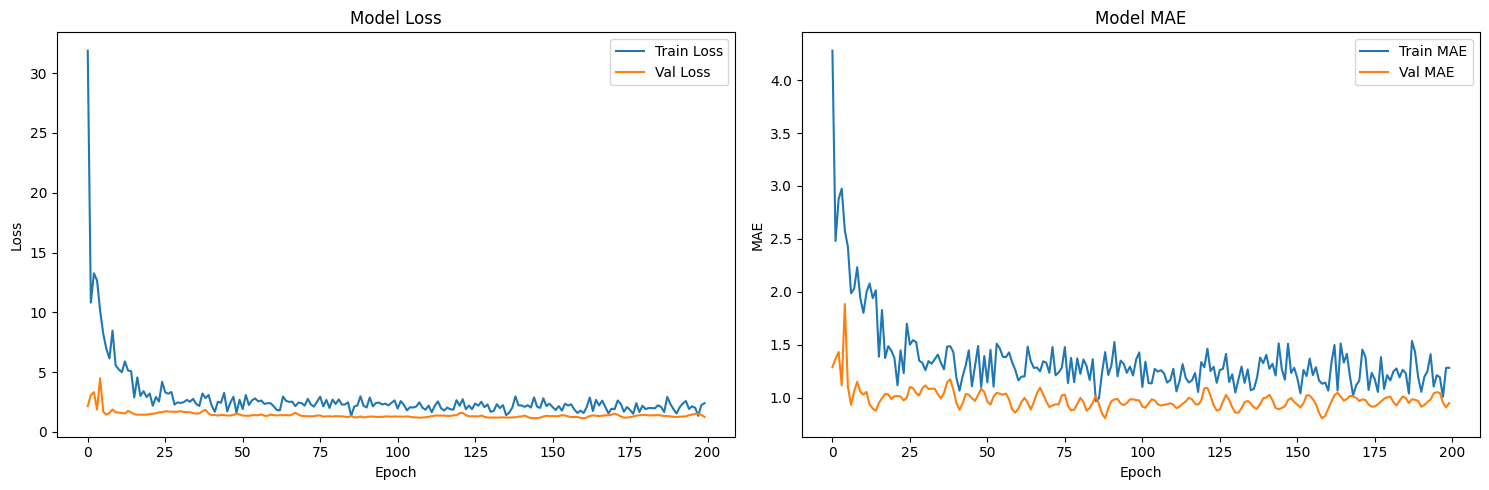

In [10]:
# Create data processor
processor = IGMCDataProcessor(ratings, movies)
processor.create_mappings()
processor.build_bipartite_graph()

# Train/test split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Create training and test data
print("Creating training data...")
X_train, y_train = create_training_data(processor, train_ratings, max_samples=3000)

print("Creating test data...")
X_test, y_test = create_training_data(processor, test_ratings, max_samples=1000)

# Prepare data for training
print("Preparing batches...")
X_train_batched, y_train_batched = pad_and_batch_data(X_train, y_train)
X_test_batched, y_test_batched = pad_and_batch_data(X_test, y_test)

print(f"Training data: {len(y_train_batched)} samples")
print(f"Test data: {len(y_test_batched)} samples")

# Create and compile the model
print("Creating IGMC model...")
model = create_model('IGMC', 
                    num_features=2,  # Adjust based on your node features
                    num_classes=1,   # For regression, this doesn't matter much
                    latent_dim=[32, 32, 16], 
                    regression=True,  # Set to True for rating prediction
                    multiply_by=5.0)  # Scale output to rating range

# Compile - use MAE for regression
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Build the model with the correct input shape
# Create a dummy input to build the model
dummy_input = [
    tf.zeros((1, 50, 2)),  # node_features: (batch, nodes, features)
    tf.zeros((1, 50, 50)), # adj_matrix: (batch, nodes, nodes)
    tf.zeros((1, 50, 1)),  # edge_features: (batch, nodes, 1)
    tf.zeros((1,), dtype=tf.int32),  # target_user_idx
    tf.zeros((1,), dtype=tf.int32),  # target_movie_idx
]

# Build the model
_ = model(dummy_input, training=False)

print("Model built successfully!")

# Prepare inputs for training (keep the same as before)
train_inputs = [
    X_train_batched['node_features'],
    X_train_batched['adj_matrix'],
    X_train_batched['edge_features'],
    X_train_batched['target_user_idx'],
    X_train_batched['target_movie_idx']
]

test_inputs = [
    X_test_batched['node_features'],
    X_test_batched['adj_matrix'],
    X_test_batched['edge_features'],
    X_test_batched['target_user_idx'],
    X_test_batched['target_movie_idx']
]

# Training
print("Training model...")
history = model.fit(
    train_inputs,
    y_train_batched,
    validation_data=(test_inputs, y_test_batched),
    epochs=200,
    batch_size=8,  # Reduce batch size if you have memory issues
    verbose=1
)

# Evaluation
print("Evaluating model...")
predictions = model.predict(test_inputs)
predictions = np.clip(predictions.flatten(), 0, 5)  # Clip between 0 and 5

mse = mean_squared_error(y_test_batched, predictions)
mae = mean_absolute_error(y_test_batched, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualization of results
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE curves
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
